- Find minimum duration (in seconds) among all users
- Find maximum gap between two events among all users

In [3]:
import keyboard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
def pr_features(g):
    pressed = g[g["direction"]==0]
    released = g[g["direction"]==1]

    pressed = pressed[pressed["time_since_beginning"].min() == pressed["time_since_beginning"]]
    released = released[released["time_since_beginning"].min() == released["time_since_beginning"]]

    if len(pressed)==0 or len(released)==0:
        return pd.DataFrame({"press":[np.nan], "release":[np.nan]})
    return pd.DataFrame({"press":[pressed.index[0]], "release":[released.index[0]]})

data = {}
for user_id in tqdm(range(1,118)):
    # Read
    try:
        df_ke = pd.read_csv(f"../dataset/full_bbmas_dataset/{user_id}/{user_id}_Desktop_Keyboard.csv")
        df_m1 = pd.read_csv(f"../dataset/full_bbmas_dataset/{user_id}/{user_id}_Mouse_Button.csv")
        df_m2 = pd.read_csv(f"../dataset/full_bbmas_dataset/{user_id}/{user_id}_Mouse_Move.csv")
        df_m3 = pd.read_csv(f"../dataset/full_bbmas_dataset/{user_id}/{user_id}_Mouse_Wheel.csv")
    except:
        continue

    data[user_id] = {}

    # Filter out cols
    df_m1 = df_m1[["pX", "pY", "LR", "state", "time"]]
    df_m2 = df_m2[["pX", "pY", "time"]]
    df_m3 = df_m3[["pX", "pY", "delta", "time"]]
    df_ke = df_ke[["key", "direction", "time"]]

    # Add operation col (denotes mouse-0 or keyboard-1)
    df_ke["operation"] = 1

    # Merge mouse data
    df_mouse = pd.merge(df_m1, df_m2, how="outer", on="time", suffixes=("","_y"))
    maskx, masky = df_mouse["pX_y"].isna(), df_mouse["pY_y"].isna()
    df_mouse.loc[~maskx, "pX"] = df_mouse.loc[~maskx, "pX_y"]
    df_mouse.loc[~masky, "pY"] = df_mouse.loc[~masky, "pY_y"]
    df_mouse.drop(["pX_y","pY_y"], axis=1, inplace=True)

    df_mouse = pd.merge(df_mouse, df_m3, how="outer", on="time", suffixes=("","_y"))
    maskx, masky = df_mouse["pX_y"].isna(), df_mouse["pY_y"].isna()
    df_mouse.loc[~maskx, "pX"] = df_mouse.loc[~maskx, "pX_y"]
    df_mouse.loc[~masky, "pY"] = df_mouse.loc[~masky, "pY_y"]
    df_mouse.drop(["pX_y","pY_y"], axis=1, inplace=True)

    # Merge keyboard data
    df = pd.merge(df_ke, df_mouse, how="outer", on="time", sort=True).reset_index(drop=True)

    # Type convert time
    df["time"] = pd.to_datetime(df["time"])
    
    # Keyboard segment length
    total_seconds = (df.iloc[len(df)-1]["time"] - df.iloc[0]["time"]).total_seconds()
    first_valid_key_index = df["key"].first_valid_index()
    last_valid_key_index = df["key"].last_valid_index()
    keyboard_time = (df.iloc[last_valid_key_index]["time"] - df.iloc[first_valid_key_index]["time"]).total_seconds()

    # Update
    data[user_id]["keyboard_time_ratio"] = keyboard_time / total_seconds
    
    # Fill delta with 0 and then forward fill
    df["delta"] = df["delta"].fillna(0)
    df["operation"] = df["operation"].fillna(0)
    df = df.fillna(method="ffill")

    # Drop non-keyboard data from the start and end
    df.drop(list(range(first_valid_key_index)) + list(range(last_valid_key_index+1,len(df))), inplace=True)

    # Fill other values
    df.loc[df["pX"].isna(), "pX"] = df["pX"].mean().round(0)
    df.loc[df["pY"].isna(), "pY"] = df["pY"].mean().round(0)
    df["LR"] = df["LR"].fillna(0)
    df["state"] = df["state"].fillna(1)

    # Normalise key name
    df["key"] = df["key"].astype(str).apply(keyboard.normalize_name)

    # Remove consecutive duplicates
    necessary_cols = [col for col in df.columns if col!="time"]
    df = df.loc[(df[necessary_cols].shift() != df[necessary_cols]).any(axis=1)]

    # Add time difference
    df["time_diff"] = (df["time"] - df["time"].shift(1)).transform(
        lambda x: x.total_seconds()
    )
    df.iloc[0, df.columns.get_loc("time_diff")] = 0
    df["time_since_beginning"] = np.cumsum(df["time_diff"])

    # Drop time column
    df.drop("time", axis=1, inplace=True)
    
    # Prepare key ids
    pressed_keys = {}
    curr_keys = set()
    key_ids = []
    key_id = 0
    for row in df.itertuples():
        key_lower = row.key.lower()
        if row.operation==1:
            if row.direction==0:
                if key_lower not in curr_keys:
                    curr_keys.add(key_lower)
                    pressed_keys[key_lower] = key_id
                    key_id += 1
            else:
                curr_keys.discard(key_lower)
        
        key_ids.append(pressed_keys.get(key_lower, -1))
    
    # Remove elements with -1 key id
    df["key_id"] = key_ids
    df = df[df["key_id"]!=-1]
    
    df_press_release = df.groupby("key_id").apply(pr_features)
    df_press_release = df_press_release.dropna().reset_index(level=1, drop=True)

    # Create press-release features
    df_press_release["press_to_press"] = np.nan
    df_press_release["release_to_press"] = np.nan
    df_press_release["hold_time"] = np.nan

    for i in range(1, len(df_press_release)):
        press_col_i = df_press_release.columns.get_loc("press")
        release_col_i = df_press_release.columns.get_loc("release")
        press_to_press_i = df_press_release.columns.get_loc("press_to_press")
        release_to_press_i = df_press_release.columns.get_loc("release_to_press")
        hold_time_i = df_press_release.columns.get_loc("hold_time")

        prev_press = df.loc[df_press_release.iloc[i-1, press_col_i], "time_since_beginning"]
        prev_release = df.loc[df_press_release.iloc[i-1, release_col_i], "time_since_beginning"]
        curr_press = df.loc[df_press_release.iloc[i, press_col_i], "time_since_beginning"]
        curr_release = df.loc[df_press_release.iloc[i, release_col_i], "time_since_beginning"]

        df_press_release.iat[i, press_to_press_i] = curr_release - curr_press
        df_press_release.iat[i, release_to_press_i] = curr_press - prev_release
        df_press_release.iat[i, hold_time_i] = curr_press - prev_press
    
    df_press_release = df_press_release.dropna()

    # Remove intm mouse data
    df = pd.merge(df, df_press_release, left_index=True, right_on="press")

    # Store
    data[user_id]["df"] = df


100%|██████████| 117/117 [10:45<00:00,  5.51s/it]


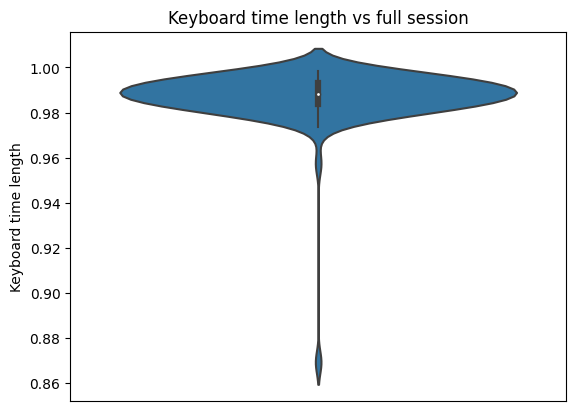

In [9]:
sns.violinplot([data[user_id]["keyboard_time_ratio"] for user_id in data])
plt.title("Keyboard time length vs full session")
plt.ylabel("Keyboard time length")
plt.xticks([])
plt.show()

In [10]:
for user_id in data:
    if data[user_id]["keyboard_time_ratio"] < 0.95:
        print("User ID:", user_id, ",", data[user_id]["keyboard_time_ratio"])

User ID: 6 , 0.8692302736703105


Only 1 user below 0.95 means we can take segment where user starts and ends typing on keyboard.

In [11]:
# Asserting that there are no null values
for user_id in data:
    missing_values = data[user_id]["df"].isnull().sum().sum()
    if missing_values>0:
        print(user_id)

In [13]:
data[1]["df"]

,key,direction,operation,pX,pY,LR,state,delta,time_diff,time_since_beginning,key_id,press,release,press_to_press,release_to_press,hold_time
key_id,,,,,,,,,,,,,,,,
1,i,0.0,1.0,1919.0,0.0,0.0,1.0,0.0,0.140,0.281,1,4,5,0.187,0.140,0.281
2,backspace,0.0,1.0,1919.0,0.0,0.0,1.0,0.0,1.217,1.685,2,6,7,0.156,1.217,1.404
3,backspace,0.0,1.0,1919.0,0.0,0.0,1.0,0.0,0.546,2.387,3,8,9,0.172,0.546,0.702
4,t,0.0,1.0,1919.0,0.0,0.0,1.0,0.0,0.577,3.136,4,10,11,0.156,0.577,0.749
5,h,0.0,1.0,1919.0,0.0,0.0,1.0,0.0,0.094,3.386,5,12,14,0.234,0.094,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,e,0.0,1.0,259.0,502.0,0.0,1.0,0.0,0.172,2747.245,5103,12753,12754,0.140,0.172,0.250
5104,.,0.0,1.0,259.0,502.0,0.0,1.0,0.0,1.170,2748.555,5104,12755,12756,0.109,1.170,1.310
5105,enter,0.0,1.0,259.0,502.0,0.0,1.0,0.0,0.874,2749.538,5105,12757,12758,0.187,0.874,0.983


In [14]:
"""
 @author    : Himanshu Mittal
 @contact   : https://www.linkedin.com/in/himanshumittal13/
 @created on: 20-09-2022 08:32:18
"""

import string
from typing import List, Dict
import keyboard


def list_punctuations() -> List[str]:
    return ["~",
        "!",
        "@",
        "#",
        "$",
        "%",
        "^",
        "&",
        "*",
        "(",
        ")",
        "_",
        "+",
        "-",
        "=",
        "[",
        "]",
        "{",
        "}",
        ":",
        ";",
        "'",
        '"',
        "\\",
        "|",
        "<",
        ",",
        ">",
        ".",
        "?",
        "/",
        "`",
    ]


def get_all_keys() -> List[str]:
    """Get all keys normalized name on keyboard"""
    misc_keys = ['ctrl']
    return [keyboard.normalize_name(key_name) for key_name in _get_all_keys()] + misc_keys


def _get_all_keys() -> List[str]:
    """Get all keys on keyboard"""
    return (
        list(string.ascii_letters)
        + list(string.digits)
        + ["F" + str(i) for i in range(1, 13)]
        + ["NUM" + str(i) for i in range(0, 10)]
        + list_punctuations()
        + [
            "TAB",
            "CAPSLOCK",
            "LSHIFT",
            "LCTRL",
            "LALT",
            "SPACE",
            "RALT",
            "RCTRL",
            "RSHIFT",
            "RETURN",
            "BACKSPACE",
            "LEFT",
            "RIGHT",
            "DOWN",
            "UP",
            "END",
            "ESCAPE",
            "DELETE",
            "HOME",
            "LWIN",
            "RWIN",
            "SHIFT",
            "ALT",
            "INSERT",
            "MENU",
            "NUM.",
            "NUM+",
            "NUM-",
            "NUM/",
            "NUM*",
            "NUMDOWN",
            "NUMLEFT",
            "NUMRIGHT",
            "NUMUP",
            "NUMEND",
            "NUMHOME",
            "NUMINS",
            "NUMDEL",
            "NUMPGDN",
            "NUMPGUP",
            "NUM LOCK",
            "PAGE DOWN",
            "PAGE UP",
        ]
    )

def get_key_category(key: str) -> str:
    # return key.lower()
    if key.lower() in ["a","t","h","s","i","n","r","e","l","space","return","backspace"]:
        return key.lower()
    elif key.lower() in list(string.ascii_letters):
        return "alphabet"
    elif key.lower() in list(string.digits):
        return "digit"
    elif key.lower() in list_punctuations():
        return "punctuation"
    else:
        return "others"


In [15]:
def calc_running_features(
    data: pd.DataFrame
):
    """
    Calculate running features
    [Time diff] + [holdtime per key] for n rows

    Params
    -------------------------
    data: Preprocessed sub dataframe (n rows)
    priors: Previous holdtime per key. If None, reset to 0.
    """
    all_keys = get_all_keys()
    position = {}
    i = 0
    for key in all_keys:
        if get_key_category(key) in position:
            continue
        position[get_key_category(key)] = i
        i += 1
    
    new_feature_data = []
    for i, row in enumerate(data.itertuples()):
        key_cateogry = get_key_category(row.key)
        new_feature_data.append([
            position[key_cateogry],
            row.press_to_press,
            row.release_to_press,
            row.hold_time,
        ])
    

    feature_cols = ["time_diff"]
    running_features = np.concatenate(
        (data[feature_cols].values.reshape(-1, len(feature_cols)), np.array(new_feature_data)), axis=1
    )
    return running_features

In [16]:
calc_running_features(data[1]["df"].iloc[:100])

array([[ 0.14 ,  4.   ,  0.187,  0.14 ,  0.281],
       [ 1.217, 14.   ,  0.156,  1.217,  1.404],
       [ 0.546, 14.   ,  0.172,  0.546,  0.702],
       [ 0.577,  9.   ,  0.156,  0.577,  0.749],
       [ 0.094,  3.   ,  0.234,  0.094,  0.25 ],
       [ 0.062,  4.   ,  0.234, -0.172,  0.062],
       [ 0.062,  8.   ,  0.11 ,  0.062,  0.296],
       [ 0.358, 13.   ,  0.156,  0.358,  0.468],
       [ 0.266,  4.   ,  0.093,  0.266,  0.422],
       [ 0.094,  8.   ,  0.078,  0.094,  0.187],
       [ 0.078, 13.   ,  0.093,  0.078,  0.156],
       [ 0.156,  0.   ,  0.156,  0.156,  0.249],
       [ 0.063, 13.   ,  0.14 ,  0.063,  0.219],
       [ 0.421,  9.   ,  0.094,  0.421,  0.561],
       [ 0.062,  2.   ,  0.063,  0.062,  0.156],
       [ 0.14 ,  8.   ,  0.203,  0.14 ,  0.203],
       [ 0.078,  9.   ,  0.203, -0.125,  0.078],
       [ 0.343, 13.   ,  0.141,  0.343,  0.546],
       [ 0.312,  9.   ,  0.14 ,  0.312,  0.453],
       [ 0.109,  1.   ,  0.047,  0.109,  0.249],
       [ 0.078, 13. 

In [17]:
def calc_summary_features(data: pd.DataFrame) -> np.ndarray:
    """
    Get summary features (get single aggregated vector for n rows)

    Params
    -------------------------
    data: Preprocessed sub dataframe (n rows)
    """
    # Time length of the events
    col_index = data.columns.get_loc("time_since_beginning")
    time_length = data.iloc[len(data)-1, col_index] - data.iloc[0, col_index]

    # Mouse velocity
    # shifted_data = data.shift(1)
    # avg_mouse_velocity = np.mean(np.sqrt((data["pX"] - shifted_data["pX"])**2 + (data["pY"] - shifted_data["pY"])**2) / data["time_diff"])

    # Space In/Out Hold
    # press_indices = data.loc[data["key"].str.lower()=="space"].index

    # press_indices = [data.iloc[i, data.columns.get_loc("time_diff")] for i in press_indices if i<len(data)]
    # avg_space_in_hold = np.mean(press_indices) if len(press_indices)>0 else 0

    # Space Enter Ratio
    space_ratio = len(data[data["key"].str.lower()=="space"])
    enter_ratio = len(data[data["key"].str.lower()=="return"])

    return np.array([time_length, space_ratio, enter_ratio])

In [18]:
calc_summary_features(data[1]["df"].iloc[:100])

array([34.851, 22.   ,  0.   ])